In [1]:
import shapefile as shp
import matplotlib.pyplot as plt
import gdal
import cv2
import osr
import numpy as np
import georaster

In [2]:
def make_latlong_transform(ds):
    """Takes a ReadingImageProvider & constructs the latlong 
    transform from it. Returns a function (x,y)-->(lat, long)"""
    old_cs = osr.SpatialReference()
    old_cs.ImportFromWkt(ds.GetProjectionRef())

    wgs84_wkt = """
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.01745329251994328,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]]"""
    new_cs = osr.SpatialReference()
    new_cs.ImportFromWkt(wgs84_wkt)
    transform = osr.CoordinateTransformation(old_cs, new_cs)

    def unpack(latlong):
        return latlong[1], latlong[0]
    
    return lambda x, y: unpack(transform.TransformPoint(x, y))

In [3]:
def load_img(src, tiff=False):
    has_alpha = 0
    src_ds = gdal.Open(src, gdal.GA_ReadOnly)
    if tiff:
        return src_ds
    last_channel = src_ds.RasterCount + (1 if not has_alpha else 0)
    arr = [src_ds.GetRasterBand(idx).ReadAsArray() for idx in range(1, last_channel)]
    return flip(np.dstack(arr))

def flip(img):
    c = 0
    return cv2.copyMakeBorder(img, c, c, c, c, cv2.BORDER_REFLECT)

(352729.0, 353753.0, 3089600.0, 3090624.0)

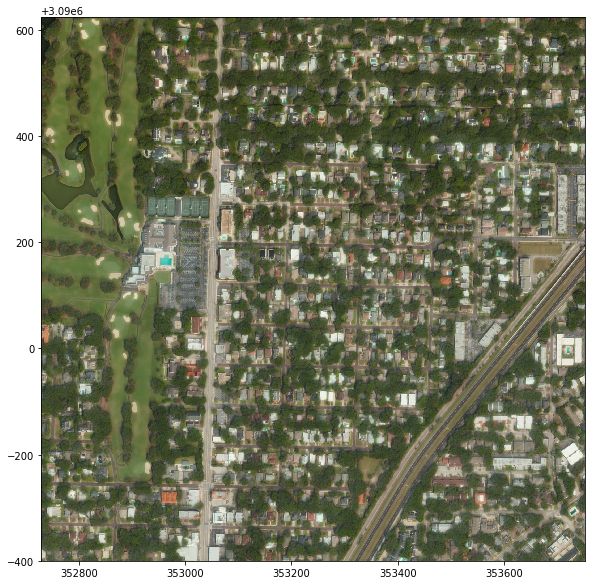

In [58]:
fname = '../../Train/Inputs/TAM_Tile_099_RGB.tif'
img = load_img(fname, tiff=False)
plt.figure(figsize=(10,10))
geo_img = georaster.MultiBandRaster(fname, load_data=False)
plt.imshow(img, extent=geo_img.extent)
geo_img.extent

63 0 0.5931944847106934


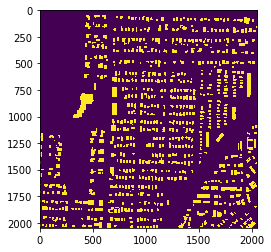

In [57]:
lblname='../../Train/GT/TAM_Tile_099_GTL.tif'
geo_lbl = georaster.SingleBandRaster(lblname)
lbl = geo_lbl.r - 2
plt.imshow(lbl, extent=geo_lbl.extent)
print(lbl.max(), lbl.min(), lbl.mean())
retval, dst = cv2.threshold(lbl, 0.5, maxval=lbl.max(), type=0)
im2, contours, hierarchy = cv2.findContours(dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(dst)

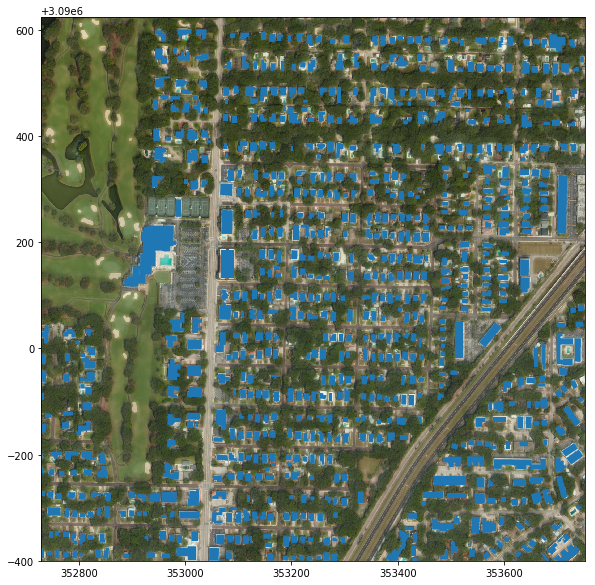

In [56]:
from matplotlib.collections import PatchCollection
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img, extent=geo_img.extent)
p = []
for poly in contours:
    pts = np.array(poly).squeeze()
    xs, ys = geo_img.coordinates(Xpixels=list(pts[:, 0]), Ypixels=list(pts[:, 1]))
    p.append(plt.Polygon(np.vstack([xs, ys]).T))
ax.add_collection(PatchCollection(p))
xs, ys = geo_img.coordinates([0, len(img)], [0, img.shape[1]-1], latlon=True)
plt.show()

In [60]:
from pytorch_utils.train import Estimator, models, losses, optimizers

In [78]:
checkpoint = 'results/weights/resnet34_/fold4_best.pth'
est = Estimator(models['resnet34'](num_classes=1, num_channels=4), 
                optimizers['adam'], losses['bce_dice_loss'], 'results/')

In [79]:
est.resume('weights/resnet34_/fold4_best.pth')

TypeError: 'Resnet34_upsample' object is not subscriptable

In [84]:
ckpt = torch.load(checkpoint)

In [81]:
import torch

In [68]:
import os.path as path

In [69]:
path.exists(checkpoint)

True